In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=16
CHANNELS=3
EPOCHS=50

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Datas/fire_dataset",shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size= BATCH_SIZE)

Found 1014 files belonging to 2 classes.


In [4]:
class_names=dataset.class_names
class_names

['fire_images', 'non_fire_images']

(16, 256, 256, 3)
[0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0]


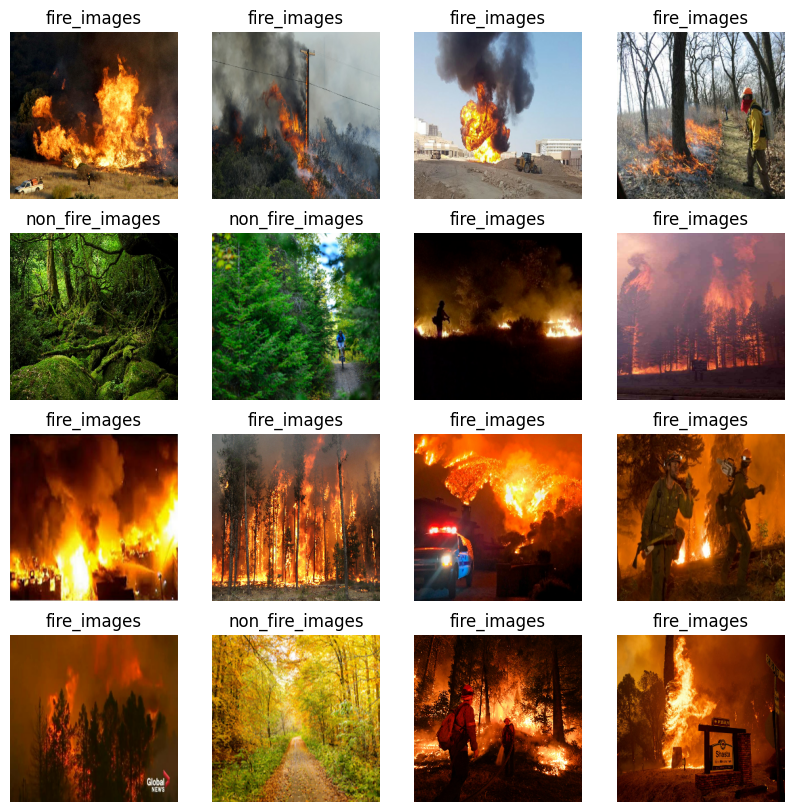

In [5]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())
  for i in range(16):
    axisx=plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  assert(train_split+test_split+val_split)==1
  ds_size = len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=6)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

51

In [9]:
len(val_ds)

6

In [10]:
len(test_ds)

7

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy()/255)

[[[0.6414784  0.23363528 0.        ]
  [0.64806783 0.23671672 0.        ]
  [0.6642855  0.23767532 0.        ]
  ...
  [0.6864362  0.23153423 0.00154036]
  [0.6773683  0.22682089 0.00350797]
  [0.6510723  0.20793505 0.        ]]

 [[0.646921   0.23907782 0.        ]
  [0.6561734  0.24482231 0.        ]
  [0.680719   0.2501327  0.0030739 ]
  ...
  [0.69328016 0.23560049 0.        ]
  [0.6745098  0.22420044 0.        ]
  [0.6683517  0.22521447 0.        ]]

 [[0.6484222  0.23665747 0.        ]
  [0.6673407  0.24505208 0.        ]
  [0.6819275  0.25447652 0.        ]
  ...
  [0.703462   0.2407169  0.        ]
  [0.6810202  0.2266288  0.        ]
  [0.6814338  0.234375   0.00150123]]

 ...

 [[0.08883272 0.1280484  0.17510723]
  [0.08451802 0.1237337  0.16377659]
  [0.08046528 0.11683517 0.1529802 ]
  ...
  [0.         0.00392157 0.        ]
  [0.         0.00392157 0.        ]
  [0.         0.00392157 0.        ]]

 [[0.07213542 0.10350797 0.15448835]
  [0.06811583 0.09548711 0.14846814]


In [13]:
resizing_and_rescaling=tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [14]:
data_augmentation=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),layers.experimental.preprocessing.RandomRotation(0.2)])

In [15]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=2
model=models.Sequential([
    resizing_and_rescaling,
    data_augmentation,
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                  

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
51/51 [==============================] - 157s 355ms/step - loss: 0.3453 - accuracy: 0.8635 - val_loss: 0.2767 - val_accuracy: 0.9583
Epoch 2/50
51/51 [==============================] - 2s 44ms/step - loss: 0.2095 - accuracy: 0.9318 - val_loss: 0.1015 - val_accuracy: 0.9479
Epoch 3/50
51/51 [==============================] - 2s 42ms/step - loss: 0.1793 - accuracy: 0.9380 - val_loss: 0.1549 - val_accuracy: 0.9688
Epoch 4/50
51/51 [==============================] - 2s 41ms/step - loss: 0.1505 - accuracy: 0.9529 - val_loss: 0.1016 - val_accuracy: 0.9479
Epoch 5/50
51/51 [==============================] - 2s 42ms/step - loss: 0.1436 - accuracy: 0.9578 - val_loss: 0.1276 - val_accuracy: 0.9375
Epoch 6/50
51/51 [==============================] - 2s 41ms/step - loss: 0.1732 - accuracy: 0.9293 - val_loss: 0.0628 - val_accuracy: 0.9792
Epoch 7/50
51/51 [==============================] - 2s 43ms/step - loss: 0.1798 - accuracy: 0.9392 - val_loss: 0.0582 - val_accuracy: 0.9792
Epoch 8/50

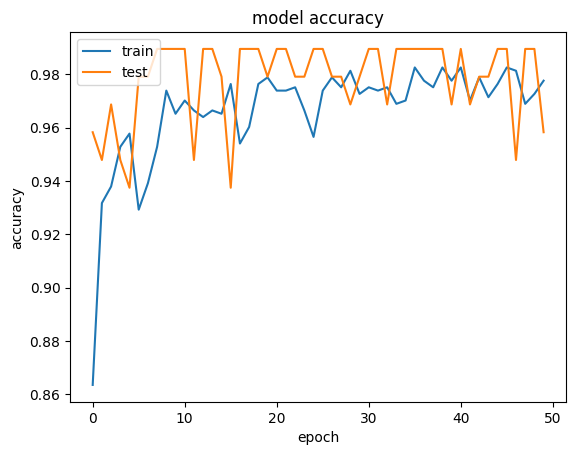

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

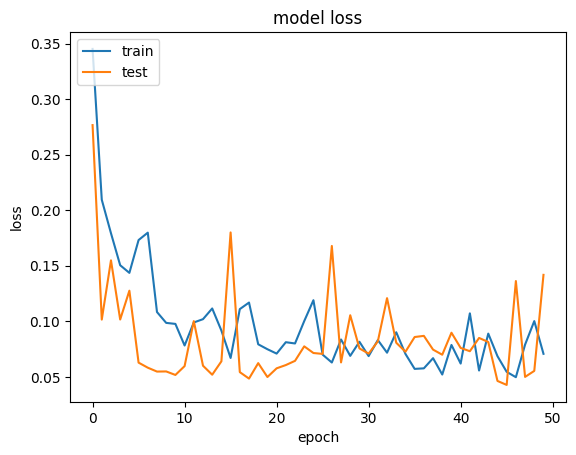

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [21]:
scores=model.evaluate(test_ds)

7/7 [==============================] - 14s 22ms/step - loss: 0.2094 - accuracy: 0.9107


In [22]:
def predict (model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


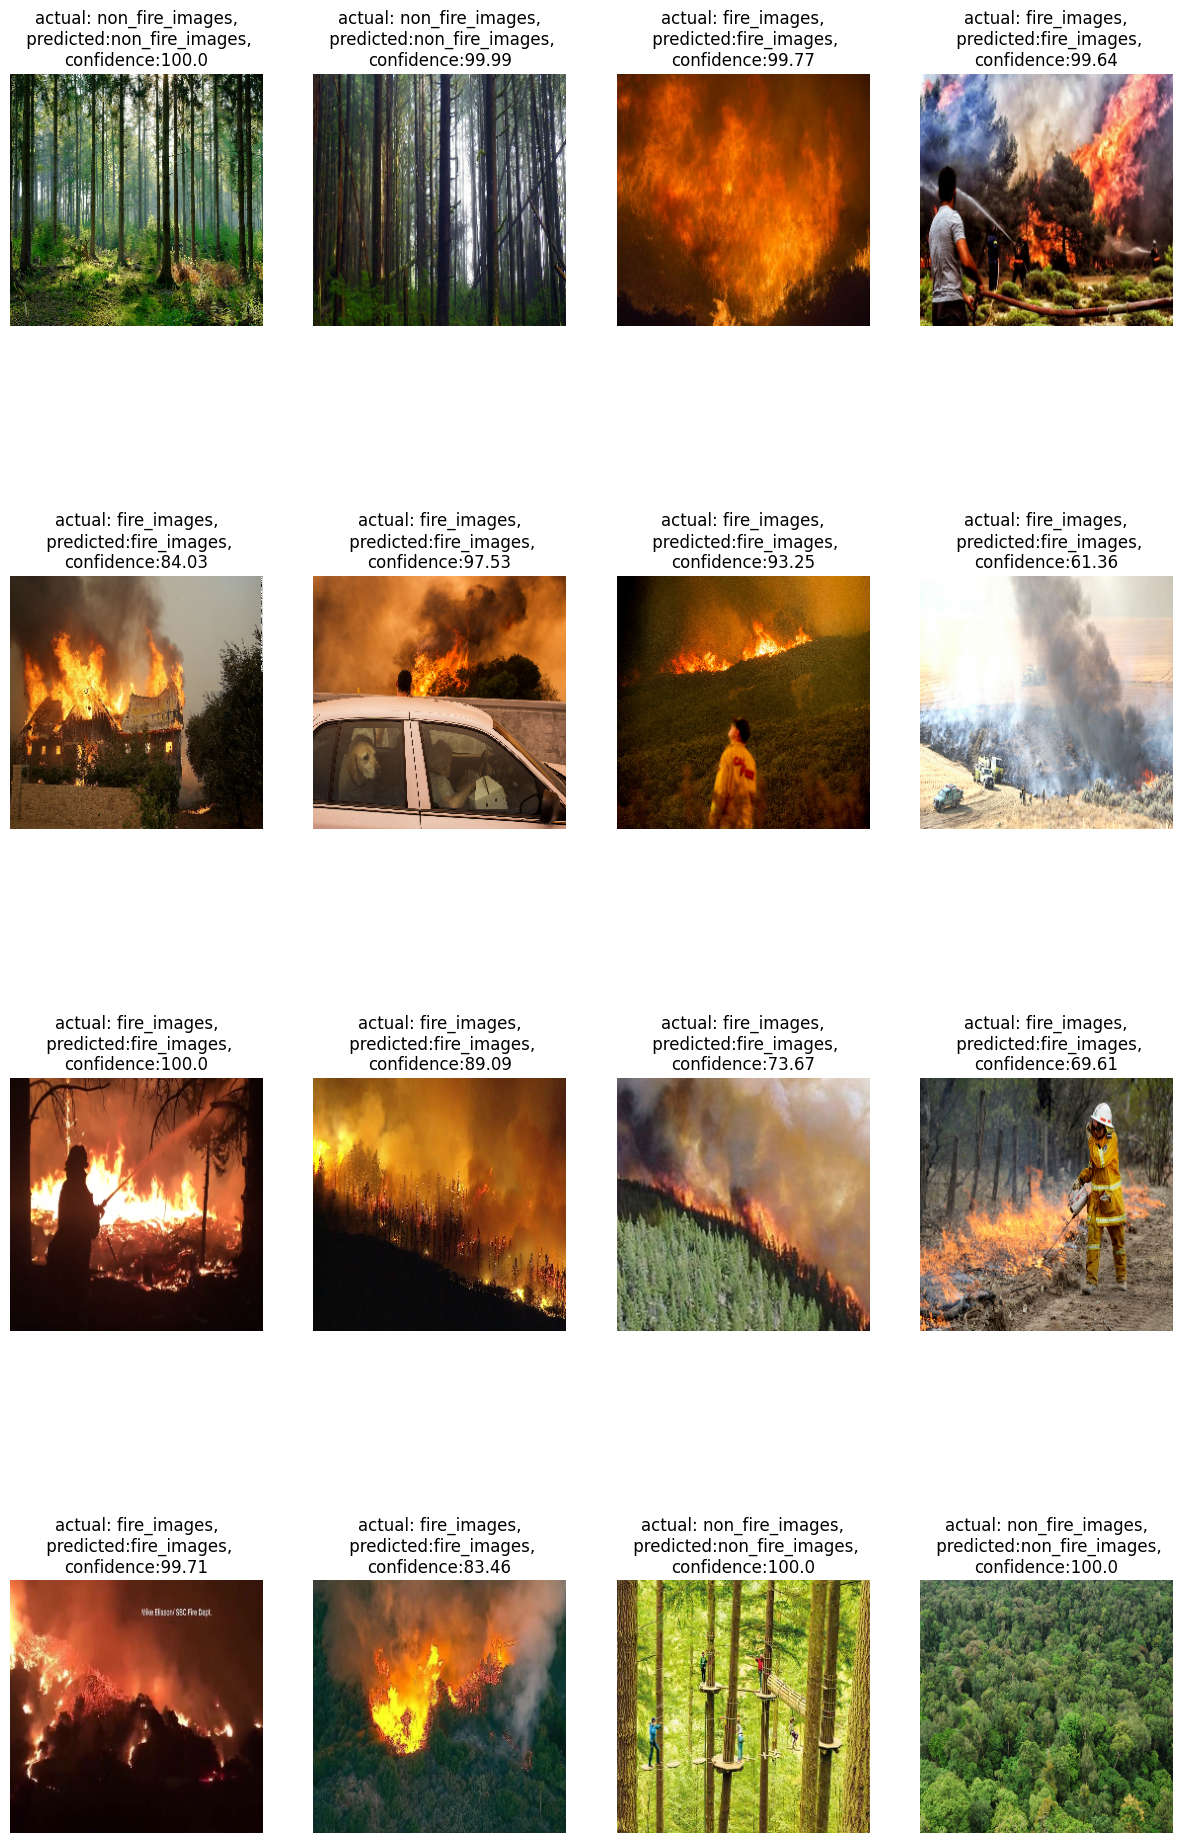

In [23]:
import numpy as np
plt.figure(figsize=(15,25))
for images,labels in test_ds.take(1):
  for i in range(16):
    axisx=plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"actual: {actual_class},\n predicted:{predicted_class},\nconfidence:{confidence}")
    plt.axis("off")

In [24]:
model.save("/content/drive/MyDrive/Model1.h5")